In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

class MazeDataset(torch.utils.data.IterableDataset):
    def __init__(self):
        self.maze_size = (16,16)
        self.room_size = 5
        
    def __iter__(self):
        return self

    def step(self, maze, y, x):
        #if self.steps > 5: return maze
        #self.steps += 1
        h,w = self.maze_size
        visited = lambda v: v[4]
        clamp = lambda v,s: min(max(0, v),self.maze_size[s]-1)
        nb = lambda dy,dx: (maze[clamp(y+dy,0),clamp(x+dx,1)], dy, dx)
        maze[y,x,4] = 1
        if y == h-1 and x == w-1:
            maze[y,x,5] = 1
        t,b = nb(-1,0), nb(1,0)
        l,r = nb(0,-1), nb(0,1)
        nbs = [t,l,r,b]
        
        for j in torch.randperm(4):
            j = j.item()
            cell,dy,dx = nbs[j]
            if visited(cell): continue
            maze[y,x,j] = 1
            maze[y+dy,x+dx,(~j)&3] = 1
            maze, c = self.step(maze, y+dy, x+dx)
            if c: maze[y,x,5] = 1
            
        return maze, maze[y,x,5]
        
    def __next__(self):
        h,w = self.maze_size 
        target = torch.zeros(h,w,6, dtype=torch.long)
        challenge = torch.zeros(h,w,6, dtype=torch.long)

        target,_ = self.step(target,0,0)
        challenge = target.clone()[None]
        challenge = torch.stack((challenge[...,4], challenge[...,2], challenge[...,3], torch.zeros_like(challenge[...,0])), 1)
        challenge = F.pixel_shuffle(challenge, 2).squeeze(1)
        target = target[None]
        target = target[...,[5]].repeat(1,1,1,4).permute(0,3,1,2)
        target = F.pixel_shuffle(target, 2).squeeze(1)
        target = challenge + (target * challenge)
        return challenge, target
        

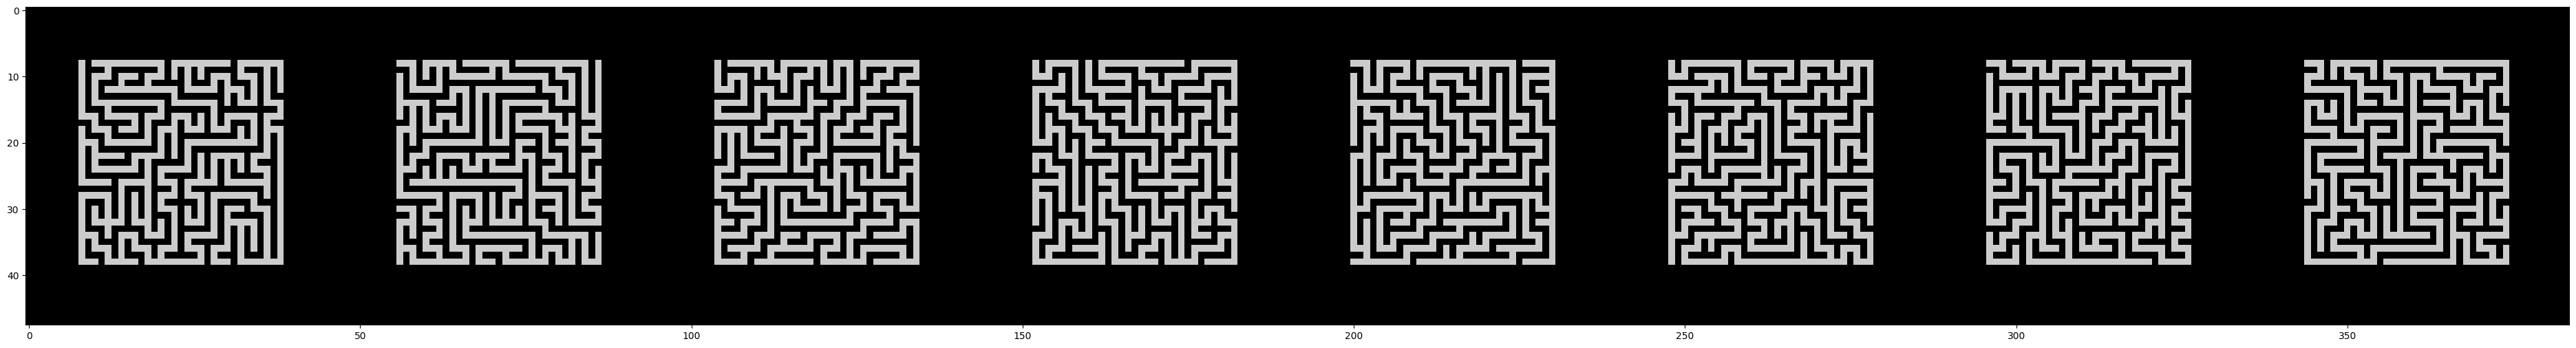

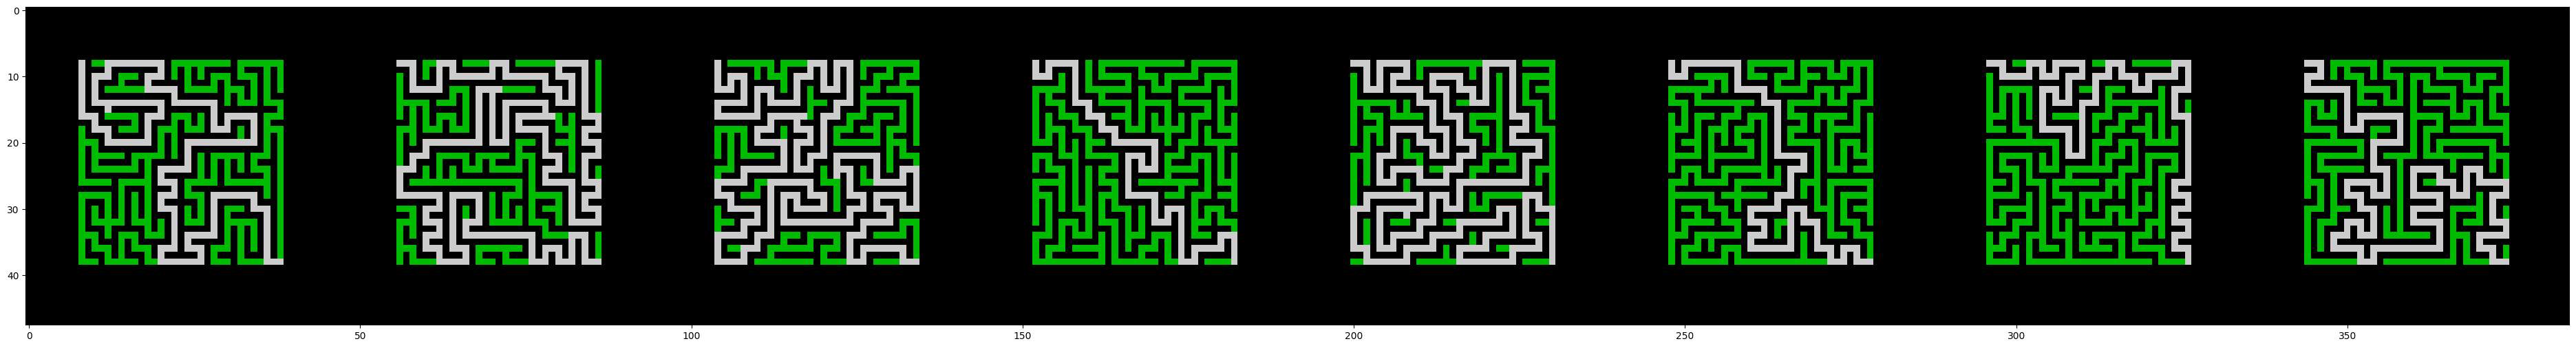

In [2]:
dataset = MazeDataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=8)
batch, target = next(iter(loader))

batch = torch.cat([F.pad(b, (8,8,8,8)) for b in batch.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(batch.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()

target = torch.cat([F.pad(t, (8,8,8,8)) for t in target.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(target.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()